In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.system("taskset -p 0xff %d" % os.getpid())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.Session(config=config)
%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np

def _read_csv(data_dir, file_name):
    import csv
    with open(data_dir + '/' + file_name + '.csv', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        return list(reader)

def _read_text(data_dir, file_name):
    with open(data_dir + '/' + file_name + '.txt', 'r') as textfile:
        return textfile.readlines()
    
def _translate(text, alphabet):
    dictionary = dict(zip(alphabet, range(len(alphabet))))
    return np.array([dictionary[t] for t in text if t != '\n'])
    
alphabet = _read_csv('../data/part1-data', 'alphabet')[0]
P = np.array(_read_csv('../data/part1-data', 'letter_probabilities')[0], dtype=np.float64)
M = np.array(_read_csv('../data/part1-data', 'letter_transition_matrix'), dtype=np.float64)
cipher_function = _read_csv('../data/part1-data', 'cipher_function')[0]
plaintext = _read_text('../data/part1-data', 'plaintext')[0]
ciphertext = _read_text('../data/part1-data', 'ciphertext')[0]
traintext = _read_text('../data/part2-data', 'plaintext_warandpeace')[0]

logP = np.log(P)
M[M==0] = 1
logM = np.log(M)

plaincode = _translate(plaintext, alphabet)
ciphercode = _translate(ciphertext, alphabet)
traincode = _translate(traintext, alphabet)
f_true = _translate(cipher_function, alphabet)
start_idx = np.array([0]+list(np.where(np.logical_and(traincode[:-1]==27,traincode[1:]==26))[0]+2))

In [3]:
from keras.utils import np_utils
import scipy.stats as stats

def _roll(x, k):
    idx = np.random.choice(x.shape[0], k, replace=False)
    xp = x.copy()
    xp[idx] = xp[np.roll(idx, 1)]
    return xp

def _gen_perm(func, order, i):
    if i % 5 == 0:
        return np.arange(order)
    return _roll(func, 2)

def _gen_data(alphabet, traincode, start_idx, length, batch_size, num_iter):
    order = len(alphabet)
    pt_data, ct_data, func_data, ktau_data= [], [], [], []
    func = None
    for i in range(num_iter*batch_size):
        start = np.random.choice(start_idx[:-5], 1)[0]
        pt = traincode[start:start+length]
        func = _gen_perm(func, order, i)
        ct = func[pt]
        ktau = stats.kendalltau(np.arange(order), func)[0]
        pt_data.append(np_utils.to_categorical(pt, order))
        ct_data.append(np_utils.to_categorical(ct, order))
        func_data.append(np_utils.to_categorical(func, order))
        ktau_data.append(ktau)
        if (i+1) % batch_size == 0:
            print('Progress: {:1.2f}%'.format((i+1)*100.0/num_iter/batch_size), end='\r')
    data = [pt_data, ct_data, func_data, ktau_data]
    return tuple([np.array(d) for d in data])

pt, ct, func, ktau = _gen_data(alphabet, traincode, start_idx, 64, 128, 100)
x = ct
y = np.exp(ktau-1)

Using TensorFlow backend.


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


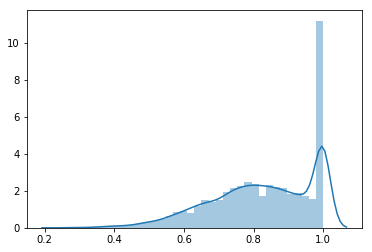

In [4]:
import seaborn as sns
sns.distplot(ktau)

In [6]:
from keras.models import Model
from keras.layers import Input, Dense, GRU, Reshape, Lambda
from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.metrics import mean_squared_error

def _check_shape(x):
    print(x.shape)
    return x

def _def_model(length, batch_size, order):
    ipt = Input(batch_shape=(batch_size, length, order))
    x = GRU(256, activation='relu', recurrent_activation='sigmoid',
            use_bias=True, kernel_initializer='glorot_uniform', 
            recurrent_initializer='orthogonal', bias_initializer='zeros',
            return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(ipt)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    pdt = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=ipt, outputs=pdt)
    model.compile('adam', loss=['mse'], metrics=['mse'])
    return model
    
model = _def_model(64, 128, 28)
history = model.fit(x=x, y=y, batch_size=128, epochs=30, verbose=1, validation_split=0.2, shuffle=True)

Train on 10240 samples, validate on 2560 samples
Epoch 1/30
10240/10240 [==============================] - 7s 684us/step - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 2/30
10240/10240 [==============================] - 6s 611us/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 3/30
10240/10240 [==============================] - 7s 635us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 4/30
10240/10240 [==============================] - 6s 619us/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 5/30
10240/10240 [==============================] - 6s 608us/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 6/30
10240/10240 [==============================] - 6s 631us/step - loss: 0.0131 - mean_squared_error: 0.

In [51]:
def get_log_probs_nn(x, model, ciphercode, batch_size, length, order):
    xinv = np.argsort(x, axis=1)
    decodedcode = xinv[:,ciphercode[:batch_size*length].reshape(batch_size, length)].reshape((xinv.shape[0]*batch_size, length))
    probs = model.predict(np_utils.to_categorical(decodedcode, order), batch_size=batch_size).reshape((xinv.shape[0], batch_size))
    return np.sum(np.log(probs), axis=1)

def get_log_probs_mc(x, logP, logM, ciphercode):
    ps = np.zeros((x.shape[0], ciphercode.shape[0]))
    xinv = np.argsort(x, axis=1)
    ps[:,0] = logP[xinv[:,ciphercode[0]]]
    ps[:,1:] = logM[xinv[:,ciphercode[1:]],xinv[:,ciphercode[:-1]]]
    return np.sum(ps, axis=1)


x = np.array([_roll(f_true, i) for i in range(1,5)])

print('ref', [stats.kendalltau(f_true, func)[0] for func in funcs])
print('mc', get_log_probs_mc(x, logP, logM, ciphercode[:64*128]))
print('nn', get_log_probs_nn(x, model, ciphercode, 128, 64, 28))

ref [1.0, 0.91005291005291, 0.8201058201058201, 0.8253968253968254, 0.8201058201058201]
mc [-19194.68082971 -23099.67510999 -23172.68760008 -26370.6917371 ]
nn [-16.811523 -23.578835 -23.62807  -29.830841]


In [21]:
def initialize(batch_size, order):
    x = np.zeros((batch_size, order), dtype=np.float64)
    for i in range(batch_size):
        x[i,] = np.random.permutation(order)
    return x

def proposal_change(x, k):
    def _roll(_x):
        idx = np.random.choice(_x.shape[0], k, replace=False)
        _x[idx] = _x[np.roll(idx, 1)]
        return _x
    xp = np.apply_along_axis(_roll, 1, np.copy(x))
    return xp

def get_log_probs(x, model, ciphercode, batch_size, order):
    xinv = np.argsort(x, axis=1)
    return np.log(model.predict(np_utils.to_categorical(xinv[:,ciphercode], order), 
                                batch_size=batch_size)).reshape(-1)

def random_step(logpr):
    pr = np.exp(np.clip(logpr, -np.inf, 0))
    return (np.random.rand(pr.shape[0]) < pr).astype(np.int)

def update(x, xp, rs):
    rs = rs.reshape((rs.shape[0],1))
    return (rs*xp+(1-rs)*x)

def get_acc(x, ciphercode, plaincode):
    xinv = np.argsort(x, axis=1)
    plaincode = np.repeat(plaincode.reshape((1,-1)), x.shape[0], axis=0)
    return np.sum((xinv[:,ciphercode] == plaincode).astype(np.int))/x.shape[0]/ciphercode.shape[0]


def main(batch_size, order, length, model, ciphercode, plaincode, maxiter, T):
    x = initialize(batch_size, order)
    rs_mean = 0
    logp_list, accept_rate_list, acc_list = [], [], []
    for i in range(maxiter):
        xp = proposal_change(x, 2)
        logp = get_log_probs(x, model, ciphercode, batch_size, order, length)
        logp_list.append(np.mean(logp))
        logpp = get_log_probs(xp, model, ciphercode, batch_size, order, length)
        logpr = logpp - logp
        rs = random_step(logpr)
        accept_rate_list.append(np.mean(rs))
        rs_mean += np.mean(rs)/T
        x = update(x, xp, rs)
        acc = get_acc(x, ciphercode, plaincode)
        acc_list.append(np.mean(acc))
        if i % T == 0:
            print("iter:{}, log_prob:{:1.4e}, accept_rate:{:1.4e}, accuracy:{:1.4e}".format(i, np.mean(logp), rs_mean, acc))
            rs_mean = 0
    return logp_list, accept_rate_list, acc_list

length = -1
logp_list, accept_rate_list, acc_list = main(32, 28, 16, model, ciphercode[:length], plaincode[:length], 5000, 100)

TypeError: get_log_probs() takes 5 positional arguments but 6 were given